# 02 - Conditional Normalizing Flow for Joint and Conditional sampling. 
This notebook is the second in the tutorial series for InvertibleNetworks.jl. In this tutorial, we will show how to train a Normalizing Flow (NF) to sample from a joint distribution $p(x,y)$. Pairing joint distribution training with conditional normalizing flows allows us to sample from the conditional distribution and therefore the posterior distribution of an inverse problem. We will use the conditional normalizing flow architecture given by [HINT (Kruse, Jakob, et al.)](https://arxiv.org/pdf/1905.10687.pdf).

The HINT architecture implements:
* HINT recursive couplying layer for increased expressiveness
* HINT conditional couplying layer for conditional samplying
* Other layers: ActNorms, 1x1 Convolutions




In [18]:
using InvertibleNetworks
using LinearAlgebra
using PyPlot
using Flux
using Random

PyPlot.rc("font", family="serif"); 

# Prior distribution - Rosenbrock

In [19]:
n_train = 60000;
X_train = sample_banana(n_train);
size(X_train) #(nx, ny, n_channels, n_samples) Note: we put 2 dimensions as channels

(1, 1, 2, 60000)

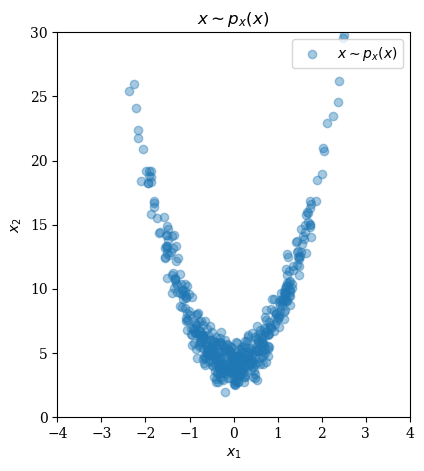

In [20]:
plot_num = 500

fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"x \sim p_x(x)")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p_{x}(x)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

# Linear inverse problem with Gaussian additive noise

As a stylized example, we will solve an inverse problem given linear measurements of a model $x$ through a compressive sensing operator $A$. We will also add gaussian additive noise and the result will be our observed data.   
$$y = Ax + \epsilon$$

Even though we will chose an $A$ that will be invertible, the added noise makes this problem ill-posed. Therefore for a given datapoint $y$ there is not a single model $x$ which solves the inverse problem. Instead there is a whole distribution of models $p(x|y)$, the conditional distribution. In this context, this is also called the posterior distribution. 

Note: we could also use a non-linear operator.

First we make an our linear measurement operator:

In [21]:
# Random seed
Random.seed!(8)

# Linear forward operator
A = randn(Float32,2,2)
A = A / (2*opnorm(A)); 

Then use this operator to make training data $Y_{train}$

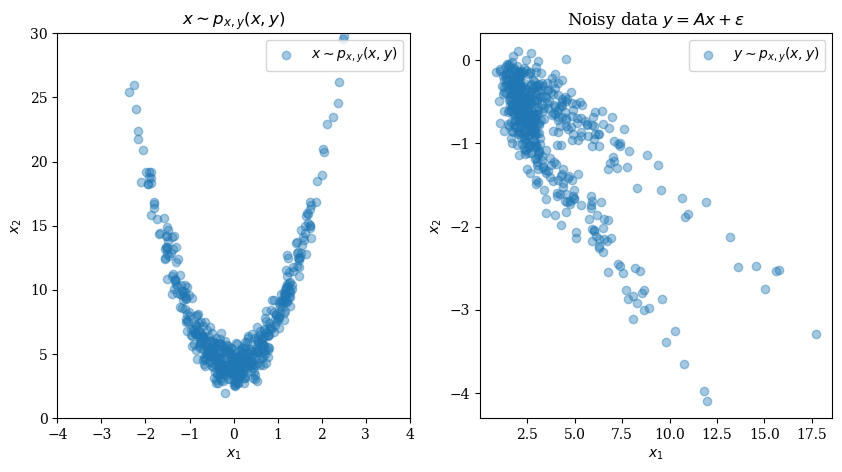

In [23]:
Y_train = reshape(A*reshape(X_train, :, n_train), nx, ny, n_in, n_train)
Y_train += .2f0*randn(Float32, nx, ny, n_in, n_train)

fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"x \sim p_{x,y}(x,y)")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p_{x,y}(x,y)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,2,2); title(L"Noisy data $y = Ax + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p_{x,y}(x,y)");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

## Training a conditional normalizing flow. 

A conditional normalizing flow is trained by learning the joint distribution $p(x,y)$ this is done in the same way as a non-conditional normalizing flow is trained my minimizing the negative log likelihood (Refer to Tutorial notebook 01 for more details. )

In [24]:
function loss(H, X, Y)
    batch_size = size(X)[end] 
    
    Zx, Zy, lgdet = H.forward(X, Y)
    l2_loss = 0.5*norm(tensor_cat(Zx, Zy))^2 / batch_size  #likelihood under Normal Gaussian training 
    
    #gradients under Normal Gaussian training
    dZx = Zx / batch_size 
    dZy = Zy / batch_size 
    
    H.backward(dZx, dZy, Zx, Zy) #sets gradients of G wrt output and also logdet terms
    
    return (l2_loss, lgdet)
end

loss (generic function with 1 method)

In [25]:
# Define network
nx = 1
ny = 1
n_in = 2
n_hidden = 64
batchsize = 64
depth = 8

# Construct HINT network
H = NetworkConditionalHINT(n_in, n_hidden, depth; k1=1, k2=1, p1=0, p2=0)

# Training
maxiter = 1000
lr      = 1f-3
lr_decay_step = 100

#compose adam optimizer with exponential learning rate decay 
opt = Flux.Optimiser(ExpDecay(lr, .9f0, lr_decay_step, 1f-6), Flux.ADAM(lr))

loss_l2_list    = zeros(maxiter)
loss_lgdet_list = zeros(maxiter)

for j=1:maxiter

    # Evaluate objective and gradients
    X = sample_banana(batchsize)
    Y = reshape(A*reshape(X, :, batchsize), nx, ny, n_in, batchsize)
    Y += .2f0*randn(Float32, nx, ny, n_in, batchsize)

    losses = loss(H, X, Y)
    loss_l2_list[j]    = losses[1]
    loss_lgdet_list[j] = losses[2]
    
    print("Iter : iteration=", j, "/", maxiter, ", batch=", 
            "; f l2 = ",   loss_l2_list[j], 
            "; f lgdet = ",loss_lgdet_list[j], 
            "; f nll objective = ",loss_l2_list[j] - loss_lgdet_list[j], "\n")

    # Update params
    for p in get_params(H)
        Flux.update!(opt, p.data, p.grad)
    end
end


Iter : iteration=1/1000, batch=; f l2 = 0.735795795917511; f lgdet = -7.42444372177124; f nll objective = 8.160239517688751
Iter : iteration=2/1000, batch=; f l2 = 0.6558642983436584; f lgdet = -7.200704097747803; f nll objective = 7.856568396091461
Iter : iteration=3/1000, batch=; f l2 = 0.700705885887146; f lgdet = -6.874777317047119; f nll objective = 7.575483202934265
Iter : iteration=4/1000, batch=; f l2 = 0.549181342124939; f lgdet = -6.6097493171691895; f nll objective = 7.158930659294128
Iter : iteration=5/1000, batch=; f l2 = 0.6197274327278137; f lgdet = -6.228055477142334; f nll objective = 6.847782909870148
Iter : iteration=6/1000, batch=; f l2 = 1.0919137001037598; f lgdet = -5.6255598068237305; f nll objective = 6.71747350692749
Iter : iteration=7/1000, batch=; f l2 = 1.1336252689361572; f lgdet = -5.256188869476318; f nll objective = 6.389814138412476
Iter : iteration=8/1000, batch=; f l2 = 1.091435432434082; f lgdet = -4.740677833557129; f nll objective = 5.832113265991

Iter : iteration=66/1000, batch=; f l2 = 1.8171969652175903; f lgdet = 1.317394495010376; f nll objective = 0.49980247020721436
Iter : iteration=67/1000, batch=; f l2 = 1.533668041229248; f lgdet = 1.0175832509994507; f nll objective = 0.5160847902297974
Iter : iteration=68/1000, batch=; f l2 = 1.6823064088821411; f lgdet = 1.3430603742599487; f nll objective = 0.3392460346221924
Iter : iteration=69/1000, batch=; f l2 = 1.4991464614868164; f lgdet = 1.5508251190185547; f nll objective = -0.05167865753173828
Iter : iteration=70/1000, batch=; f l2 = 1.9980449676513672; f lgdet = 1.3674650192260742; f nll objective = 0.630579948425293
Iter : iteration=71/1000, batch=; f l2 = 1.5783311128616333; f lgdet = 1.623633861541748; f nll objective = -0.045302748680114746
Iter : iteration=72/1000, batch=; f l2 = 1.5155282020568848; f lgdet = 1.6033211946487427; f nll objective = -0.08779299259185791
Iter : iteration=73/1000, batch=; f l2 = 2.106544017791748; f lgdet = 1.599643349647522; f nll objec

Iter : iteration=130/1000, batch=; f l2 = 2.337015151977539; f lgdet = 2.3863320350646973; f nll objective = -0.0493168830871582
Iter : iteration=131/1000, batch=; f l2 = 2.0436341762542725; f lgdet = 2.328892707824707; f nll objective = -0.28525853157043457
Iter : iteration=132/1000, batch=; f l2 = 1.9251973628997803; f lgdet = 2.189128875732422; f nll objective = -0.2639315128326416
Iter : iteration=133/1000, batch=; f l2 = 1.69298255443573; f lgdet = 2.1231765747070312; f nll objective = -0.43019402027130127
Iter : iteration=134/1000, batch=; f l2 = 2.0682103633880615; f lgdet = 1.9876214265823364; f nll objective = 0.0805889368057251
Iter : iteration=135/1000, batch=; f l2 = 2.151477575302124; f lgdet = 2.215867042541504; f nll objective = -0.06438946723937988
Iter : iteration=136/1000, batch=; f l2 = 2.2516064643859863; f lgdet = 2.1097776889801025; f nll objective = 0.1418287754058838
Iter : iteration=137/1000, batch=; f l2 = 1.7759472131729126; f lgdet = 2.115514039993286; f nll

Iter : iteration=194/1000, batch=; f l2 = 1.7616119384765625; f lgdet = 2.375039577484131; f nll objective = -0.6134276390075684
Iter : iteration=195/1000, batch=; f l2 = 1.4978986978530884; f lgdet = 2.241046667098999; f nll objective = -0.7431479692459106
Iter : iteration=196/1000, batch=; f l2 = 1.9145419597625732; f lgdet = 2.5388808250427246; f nll objective = -0.6243388652801514
Iter : iteration=197/1000, batch=; f l2 = 1.947342872619629; f lgdet = 2.4723129272460938; f nll objective = -0.5249700546264648
Iter : iteration=198/1000, batch=; f l2 = 1.8289412260055542; f lgdet = 2.3776016235351562; f nll objective = -0.548660397529602
Iter : iteration=199/1000, batch=; f l2 = 1.7697291374206543; f lgdet = 2.4475574493408203; f nll objective = -0.677828311920166
Iter : iteration=200/1000, batch=; f l2 = 2.211158037185669; f lgdet = 2.3332364559173584; f nll objective = -0.12207841873168945
Iter : iteration=201/1000, batch=; f l2 = 2.4212276935577393; f lgdet = 2.60937237739563; f nll

Iter : iteration=258/1000, batch=; f l2 = 2.153533458709717; f lgdet = 2.304142951965332; f nll objective = -0.15060949325561523
Iter : iteration=259/1000, batch=; f l2 = 1.8428138494491577; f lgdet = 2.3763222694396973; f nll objective = -0.5335084199905396
Iter : iteration=260/1000, batch=; f l2 = 1.9490159749984741; f lgdet = 2.2624351978302; f nll objective = -0.3134192228317261
Iter : iteration=261/1000, batch=; f l2 = 1.7893918752670288; f lgdet = 2.482740879058838; f nll objective = -0.6933490037918091
Iter : iteration=262/1000, batch=; f l2 = 2.0534119606018066; f lgdet = 2.3350329399108887; f nll objective = -0.28162097930908203
Iter : iteration=263/1000, batch=; f l2 = 1.6532080173492432; f lgdet = 2.3430511951446533; f nll objective = -0.6898431777954102
Iter : iteration=264/1000, batch=; f l2 = 1.87856125831604; f lgdet = 2.488556385040283; f nll objective = -0.6099951267242432
Iter : iteration=265/1000, batch=; f l2 = 1.918521523475647; f lgdet = 2.3062448501586914; f nll 

Iter : iteration=322/1000, batch=; f l2 = 2.0338587760925293; f lgdet = 2.466987133026123; f nll objective = -0.43312835693359375
Iter : iteration=323/1000, batch=; f l2 = 2.0220675468444824; f lgdet = 2.416922092437744; f nll objective = -0.3948545455932617
Iter : iteration=324/1000, batch=; f l2 = 1.9277706146240234; f lgdet = 2.4551308155059814; f nll objective = -0.527360200881958
Iter : iteration=325/1000, batch=; f l2 = 2.4072883129119873; f lgdet = 2.55351185798645; f nll objective = -0.1462235450744629
Iter : iteration=326/1000, batch=; f l2 = 1.8848885297775269; f lgdet = 2.440519094467163; f nll objective = -0.5556305646896362
Iter : iteration=327/1000, batch=; f l2 = 1.5096993446350098; f lgdet = 2.5105910301208496; f nll objective = -1.0008916854858398
Iter : iteration=328/1000, batch=; f l2 = 1.7431355714797974; f lgdet = 2.446946620941162; f nll objective = -0.7038110494613647
Iter : iteration=329/1000, batch=; f l2 = 2.096357822418213; f lgdet = 2.48982572555542; f nll o

Iter : iteration=386/1000, batch=; f l2 = 1.8930151462554932; f lgdet = 2.75758695602417; f nll objective = -0.8645718097686768
Iter : iteration=387/1000, batch=; f l2 = 1.8587721586227417; f lgdet = 2.7976198196411133; f nll objective = -0.9388476610183716
Iter : iteration=388/1000, batch=; f l2 = 2.232473373413086; f lgdet = 2.66357421875; f nll objective = -0.43110084533691406
Iter : iteration=389/1000, batch=; f l2 = 1.9399670362472534; f lgdet = 2.890515089035034; f nll objective = -0.9505480527877808
Iter : iteration=390/1000, batch=; f l2 = 2.0504724979400635; f lgdet = 2.901554584503174; f nll objective = -0.8510820865631104
Iter : iteration=391/1000, batch=; f l2 = 2.2105512619018555; f lgdet = 2.628457546234131; f nll objective = -0.4179062843322754
Iter : iteration=392/1000, batch=; f l2 = 2.0405848026275635; f lgdet = 2.7410311698913574; f nll objective = -0.700446367263794
Iter : iteration=393/1000, batch=; f l2 = 1.9604462385177612; f lgdet = 2.6572189331054688; f nll obj

Iter : iteration=450/1000, batch=; f l2 = 2.0671236515045166; f lgdet = 2.5029163360595703; f nll objective = -0.4357926845550537
Iter : iteration=451/1000, batch=; f l2 = 2.3010177612304688; f lgdet = 2.6002252101898193; f nll objective = -0.2992074489593506
Iter : iteration=452/1000, batch=; f l2 = 1.8936470746994019; f lgdet = 2.4458539485931396; f nll objective = -0.5522068738937378
Iter : iteration=453/1000, batch=; f l2 = 1.9170583486557007; f lgdet = 2.4896955490112305; f nll objective = -0.5726372003555298
Iter : iteration=454/1000, batch=; f l2 = 1.9615890979766846; f lgdet = 2.4206137657165527; f nll objective = -0.45902466773986816
Iter : iteration=455/1000, batch=; f l2 = 1.9840993881225586; f lgdet = 2.585050106048584; f nll objective = -0.6009507179260254
Iter : iteration=456/1000, batch=; f l2 = 1.9998340606689453; f lgdet = 2.5580108165740967; f nll objective = -0.5581767559051514
Iter : iteration=457/1000, batch=; f l2 = 1.9534507989883423; f lgdet = 2.598170042037964;

Iter : iteration=514/1000, batch=; f l2 = 1.7147161960601807; f lgdet = 2.809846878051758; f nll objective = -1.0951306819915771
Iter : iteration=515/1000, batch=; f l2 = 2.1742985248565674; f lgdet = 2.8709816932678223; f nll objective = -0.6966831684112549
Iter : iteration=516/1000, batch=; f l2 = 2.205867052078247; f lgdet = 2.840305805206299; f nll objective = -0.6344387531280518
Iter : iteration=517/1000, batch=; f l2 = 2.0400919914245605; f lgdet = 2.841893434524536; f nll objective = -0.8018014430999756
Iter : iteration=518/1000, batch=; f l2 = 1.9810725450515747; f lgdet = 2.8656671047210693; f nll objective = -0.8845945596694946
Iter : iteration=519/1000, batch=; f l2 = 2.10678768157959; f lgdet = 2.8032116889953613; f nll objective = -0.6964240074157715
Iter : iteration=520/1000, batch=; f l2 = 2.1633198261260986; f lgdet = 2.6661055088043213; f nll objective = -0.5027856826782227
Iter : iteration=521/1000, batch=; f l2 = 2.0517985820770264; f lgdet = 2.7428059577941895; f nl

Iter : iteration=578/1000, batch=; f l2 = 2.0652596950531006; f lgdet = 2.7874341011047363; f nll objective = -0.7221744060516357
Iter : iteration=579/1000, batch=; f l2 = 1.928373098373413; f lgdet = 2.7068209648132324; f nll objective = -0.7784478664398193
Iter : iteration=580/1000, batch=; f l2 = 1.9347447156906128; f lgdet = 2.8754849433898926; f nll objective = -0.9407402276992798
Iter : iteration=581/1000, batch=; f l2 = 2.22436785697937; f lgdet = 2.857121467590332; f nll objective = -0.6327536106109619
Iter : iteration=582/1000, batch=; f l2 = 1.7174913883209229; f lgdet = 2.839256763458252; f nll objective = -1.121765375137329
Iter : iteration=583/1000, batch=; f l2 = 2.1732776165008545; f lgdet = 2.860379457473755; f nll objective = -0.6871018409729004
Iter : iteration=584/1000, batch=; f l2 = 2.3192408084869385; f lgdet = 2.869614362716675; f nll objective = -0.5503735542297363
Iter : iteration=585/1000, batch=; f l2 = 1.9082931280136108; f lgdet = 2.9322304725646973; f nll 

Iter : iteration=642/1000, batch=; f l2 = 1.9406882524490356; f lgdet = 2.8871195316314697; f nll objective = -0.9464312791824341
Iter : iteration=643/1000, batch=; f l2 = 2.15535569190979; f lgdet = 2.7307889461517334; f nll objective = -0.5754332542419434
Iter : iteration=644/1000, batch=; f l2 = 1.9712802171707153; f lgdet = 2.592299222946167; f nll objective = -0.6210190057754517
Iter : iteration=645/1000, batch=; f l2 = 1.8993897438049316; f lgdet = 2.6893932819366455; f nll objective = -0.7900035381317139
Iter : iteration=646/1000, batch=; f l2 = 1.897279977798462; f lgdet = 2.662768602371216; f nll objective = -0.7654886245727539
Iter : iteration=647/1000, batch=; f l2 = 2.1494944095611572; f lgdet = 2.71402645111084; f nll objective = -0.5645320415496826
Iter : iteration=648/1000, batch=; f l2 = 2.061802387237549; f lgdet = 2.680734872817993; f nll objective = -0.6189324855804443
Iter : iteration=649/1000, batch=; f l2 = 2.3594722747802734; f lgdet = 2.9126946926116943; f nll o

Iter : iteration=706/1000, batch=; f l2 = 2.1839776039123535; f lgdet = 2.821577310562134; f nll objective = -0.6375997066497803
Iter : iteration=707/1000, batch=; f l2 = 1.9325110912322998; f lgdet = 2.7224314212799072; f nll objective = -0.7899203300476074
Iter : iteration=708/1000, batch=; f l2 = 1.9997472763061523; f lgdet = 2.73968505859375; f nll objective = -0.7399377822875977
Iter : iteration=709/1000, batch=; f l2 = 2.1467792987823486; f lgdet = 2.8428711891174316; f nll objective = -0.696091890335083
Iter : iteration=710/1000, batch=; f l2 = 2.374777317047119; f lgdet = 2.857088088989258; f nll objective = -0.48231077194213867
Iter : iteration=711/1000, batch=; f l2 = 2.042224645614624; f lgdet = 2.7377796173095703; f nll objective = -0.6955549716949463
Iter : iteration=712/1000, batch=; f l2 = 2.020998001098633; f lgdet = 2.5248303413391113; f nll objective = -0.5038323402404785
Iter : iteration=713/1000, batch=; f l2 = 1.9229336977005005; f lgdet = 2.817202091217041; f nll 

Iter : iteration=770/1000, batch=; f l2 = 1.8091638088226318; f lgdet = 2.7856998443603516; f nll objective = -0.9765360355377197
Iter : iteration=771/1000, batch=; f l2 = 2.2111899852752686; f lgdet = 2.585167169570923; f nll objective = -0.3739771842956543
Iter : iteration=772/1000, batch=; f l2 = 2.0615241527557373; f lgdet = 2.7824888229370117; f nll objective = -0.7209646701812744
Iter : iteration=773/1000, batch=; f l2 = 2.2380034923553467; f lgdet = 2.8124358654022217; f nll objective = -0.574432373046875
Iter : iteration=774/1000, batch=; f l2 = 2.0529370307922363; f lgdet = 2.8773648738861084; f nll objective = -0.8244278430938721
Iter : iteration=775/1000, batch=; f l2 = 2.0974323749542236; f lgdet = 2.9715073108673096; f nll objective = -0.8740749359130859
Iter : iteration=776/1000, batch=; f l2 = 1.9391306638717651; f lgdet = 2.8654427528381348; f nll objective = -0.9263120889663696
Iter : iteration=777/1000, batch=; f l2 = 2.061037540435791; f lgdet = 2.78948712348938; f n

Iter : iteration=834/1000, batch=; f l2 = 1.8712762594223022; f lgdet = 2.763831615447998; f nll objective = -0.8925553560256958
Iter : iteration=835/1000, batch=; f l2 = 2.322240114212036; f lgdet = 2.7637290954589844; f nll objective = -0.44148898124694824
Iter : iteration=836/1000, batch=; f l2 = 2.424211263656616; f lgdet = 2.8671374320983887; f nll objective = -0.44292616844177246
Iter : iteration=837/1000, batch=; f l2 = 1.7305965423583984; f lgdet = 2.9562602043151855; f nll objective = -1.225663661956787
Iter : iteration=838/1000, batch=; f l2 = 2.115767478942871; f lgdet = 2.9010965824127197; f nll objective = -0.7853291034698486
Iter : iteration=839/1000, batch=; f l2 = 1.935670256614685; f lgdet = 2.726923942565918; f nll objective = -0.7912536859512329
Iter : iteration=840/1000, batch=; f l2 = 1.929697036743164; f lgdet = 2.6520938873291016; f nll objective = -0.7223968505859375
Iter : iteration=841/1000, batch=; f l2 = 2.191521644592285; f lgdet = 2.6481246948242188; f nll

Iter : iteration=898/1000, batch=; f l2 = 1.7698696851730347; f lgdet = 2.7721352577209473; f nll objective = -1.0022655725479126
Iter : iteration=899/1000, batch=; f l2 = 1.9435242414474487; f lgdet = 2.7957444190979004; f nll objective = -0.8522201776504517
Iter : iteration=900/1000, batch=; f l2 = 1.879788875579834; f lgdet = 2.901707410812378; f nll objective = -1.021918535232544
Iter : iteration=901/1000, batch=; f l2 = 1.9271390438079834; f lgdet = 2.831397533416748; f nll objective = -0.9042584896087646
Iter : iteration=902/1000, batch=; f l2 = 1.9753663539886475; f lgdet = 2.8518788814544678; f nll objective = -0.8765125274658203
Iter : iteration=903/1000, batch=; f l2 = 2.049248695373535; f lgdet = 2.662393093109131; f nll objective = -0.6131443977355957
Iter : iteration=904/1000, batch=; f l2 = 1.927295446395874; f lgdet = 2.903484344482422; f nll objective = -0.9761888980865479
Iter : iteration=905/1000, batch=; f l2 = 1.909894347190857; f lgdet = 2.8033998012542725; f nll o

Iter : iteration=962/1000, batch=; f l2 = 1.8569754362106323; f lgdet = 3.0324676036834717; f nll objective = -1.1754921674728394
Iter : iteration=963/1000, batch=; f l2 = 1.8526853322982788; f lgdet = 2.9308557510375977; f nll objective = -1.0781704187393188
Iter : iteration=964/1000, batch=; f l2 = 1.928871750831604; f lgdet = 2.9205617904663086; f nll objective = -0.9916900396347046
Iter : iteration=965/1000, batch=; f l2 = 2.276247501373291; f lgdet = 2.7683677673339844; f nll objective = -0.49212026596069336
Iter : iteration=966/1000, batch=; f l2 = 1.7590376138687134; f lgdet = 2.859518527984619; f nll objective = -1.1004809141159058
Iter : iteration=967/1000, batch=; f l2 = 1.9407711029052734; f lgdet = 2.810983180999756; f nll objective = -0.8702120780944824
Iter : iteration=968/1000, batch=; f l2 = 2.041332483291626; f lgdet = 2.771088123321533; f nll objective = -0.7297556400299072
Iter : iteration=969/1000, batch=; f l2 = 2.360095500946045; f lgdet = 2.7556238174438477; f nl

## Check training objective log 
There are various ways to train a NF:
- train your network to convergence of objective
- use earlystopping to prevent overfitting 
- check normality of $Zx, Zy = H_{\theta}(Z,Y)$ with qq plots 
- as a heuristic simply observe $Zx, Zy = H_{\theta}(X, Y)$ until it looks normal under the eyeball norm. 

Note: joint distributions are harder to learn than marginal distributions. There are a few reasons including the larger dimensionality and the fact that learning a joint distribution implicitly also learns a conditional distribution. 

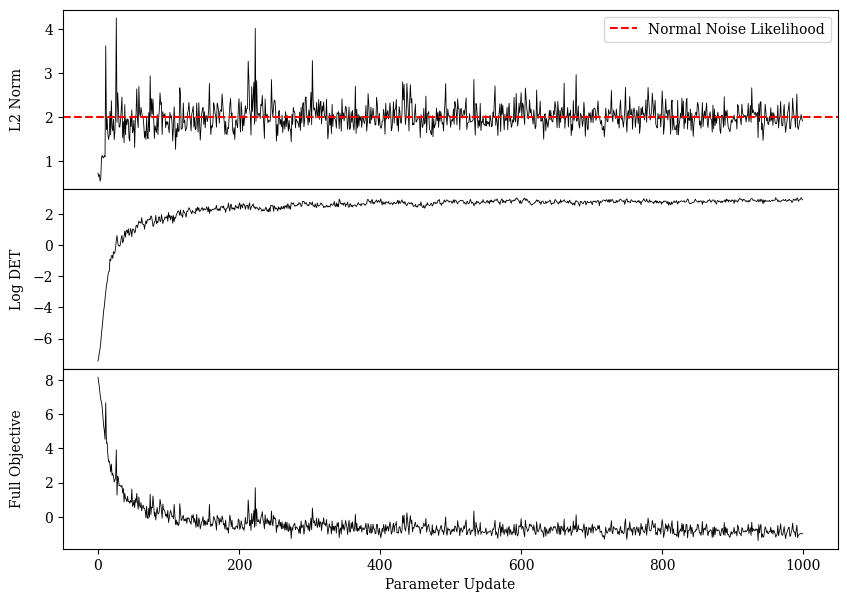

PyObject Text(0.5, 24.000000000000007, 'Parameter Update')

In [26]:
gt_l2 = 0.5*nx*ny*n_in*2 #l2 norm of noise. Note: extra 2 factor since learning a 2 rv. joint distribution

fig, axs = subplots(3, 1, sharex=true, figsize=(10,7))
fig.subplots_adjust(hspace=0)

axs[1].plot(loss_l2_list, color="black", linewidth=0.6); 
axs[1].axhline(y=gt_l2,color="red",linestyle="--",label="Normal Noise Likelihood")
axs[1].set_ylabel("L2 Norm")
axs[1].yaxis.set_label_coords(-0.05, 0.5)
axs[1].legend()

axs[2].plot(loss_lgdet_list, color="black", linewidth=0.6); 
axs[2].set_ylabel("Log DET") 
axs[2].yaxis.set_label_coords(-0.05, 0.5) 

axs[3].plot(loss_l2_list - loss_lgdet_list, color="black", linewidth=0.6); 
axs[3].set_ylabel("Full Objective") 
axs[3].yaxis.set_label_coords(-0.05, 0.5)
axs[3].set_xlabel("Parameter Update") 

## Testing a Conditional Normalizing Flow 

The first step in testing a normalizing flow is to understand what prior it has learned. In this case, we trained our network to generate samples from a joint distribution so we will first check that these generative samples look like 
 
We start with normal gaussian variables $Zx, Zy \sim N(0, I)$

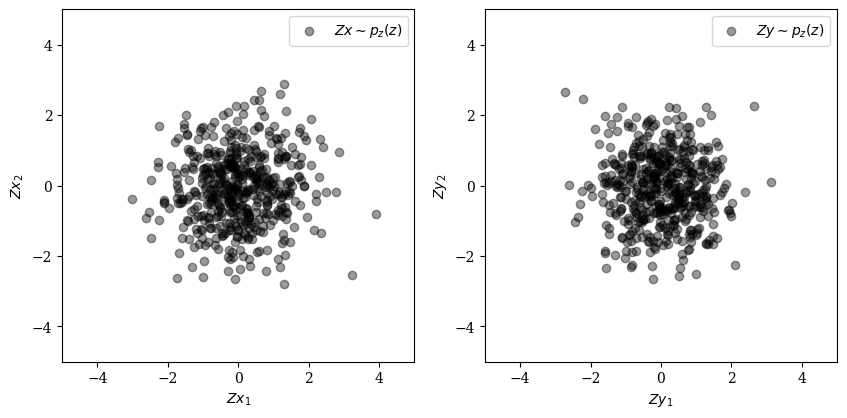

In [36]:
num_test_samples = 500;
Zx_test = randn(Float32,nx,ny,n_in, num_test_samples);
Zy_test = randn(Float32,nx,ny,n_in, num_test_samples);

fig = figure(figsize=(10,5)); 
ax1 = subplot(1,2,1)
scatter(Zx_test[1,1,1,:], Zx_test[1,1,2,:]; alpha=0.4, color="black", label = L"Zx \sim p_{z}(z)");
xlabel(L"Zx_1"); ylabel(L"Zx_2"); xlim(-5,5); ylim(-5,5);
legend(); ax1.set_aspect(1);

ax2 = subplot(1,2,2)
scatter(Zy_test[1,1,1,:], Zy_test[1,1,2,:]; alpha=0.4, color="black", label = L"Zy \sim p_{z}(z)");
xlabel(L"Zy_1"); ylabel(L"Zy_2"); xlim(-5,5); ylim(-5,5);
legend(); ax2.set_aspect(1);

Make generative samples from the joint distribution by passing both Z variables through the inverse network $ x,  y = H^{-1}_\theta(Zx,Zy)$ 

In [37]:
X_test, Y_test = H.inverse(Zx_test, Zy_test);

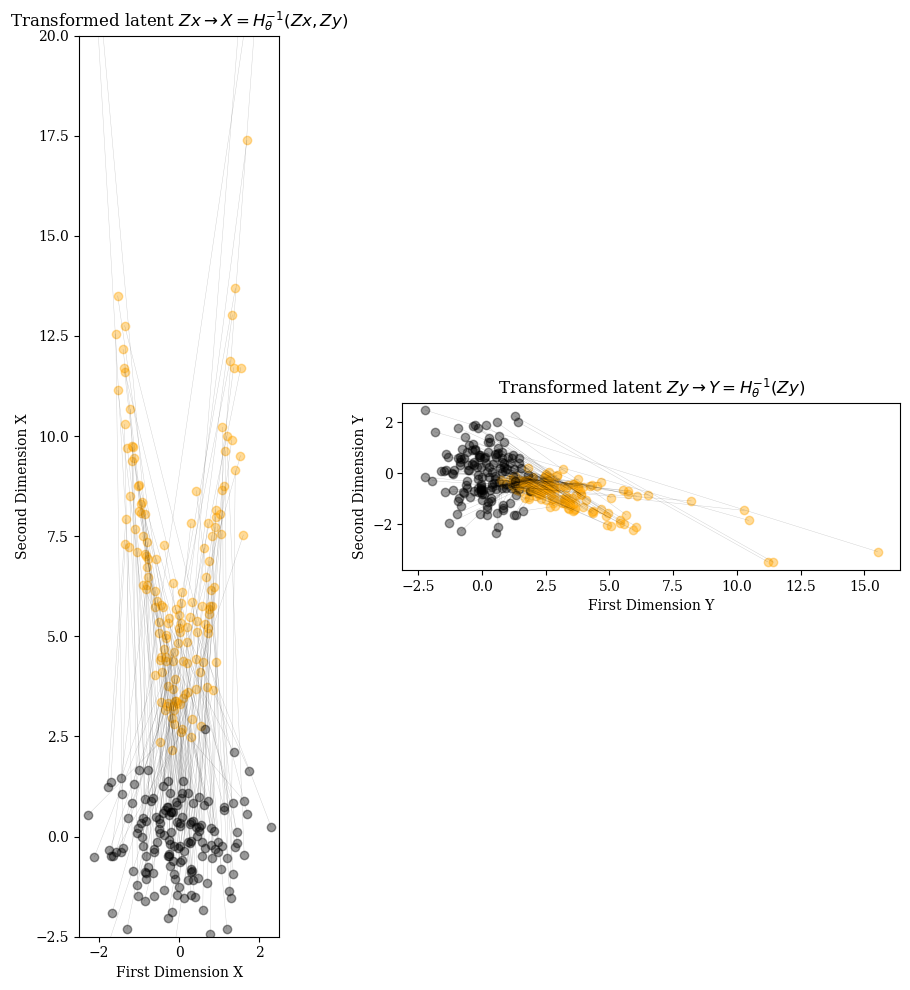

In [38]:
trans_num = 150
start_points = [(Zx_test[1,1,1,i], Zx_test[1,1,2,i]) for i in 1:trans_num]
end_points = [(X_test[1,1,1,i], X_test[1,1,2,i]) for i in 1:trans_num]

# Plot transformed Latent Zx
fig = figure(figsize=(10,10));
ax = fig.add_subplot(1,2,1); title(L"Transformed latent $Zx \rightarrow X=H^{-1}_\theta(Zx, Zy)$");

for line in zip(start_points, end_points)
    plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
    scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
    scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
end
xlabel("First Dimension X"); ylabel("Second Dimension X");
ylim(-2.5,20); xlim(-2.5,2.5); ax.set_aspect(1)

# Plot transformed Latent Zy
start_points = [(Zy_test[1,1,1,i], Zy_test[1,1,2,i]) for i in 1:trans_num]
end_points = [(Y_test[1,1,1,i], Y_test[1,1,2,i]) for i in 1:trans_num]

ax = fig.add_subplot(1,2,2); title(L"Transformed latent $Zy \rightarrow Y=H^{-1}_\theta(Zy)$");
for line in zip(start_points, end_points)
    plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
    scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
    scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
end
xlabel("First Dimension Y"); ylabel("Second Dimension Y");
ax.set_aspect(1)

tight_layout()

Visually compare generative joint samples with joint samples from the ground truth density $x, y \sim p(x,y) $

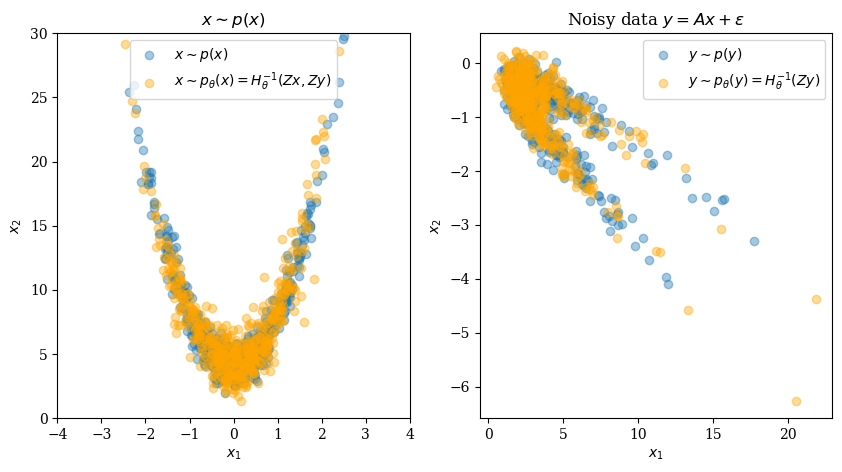

In [39]:
fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"x \sim p(x)")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x)");
scatter(X_test[1,1,1,1:plot_num], X_test[1,1,2,1:plot_num]; alpha=0.4, color="orange", label = L"x \sim p_{\theta}(x) = H_\theta^{-1}(Zx, Zy)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,2,2); title(L"Noisy data $y = Ax + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p(y)");
scatter(Y_test[1,1,1,1:plot_num], Y_test[1,1,2,1:plot_num]; alpha=0.4, color="orange", label = L"y \sim p_{\theta}(y) = H_\theta^{-1}(Zy)");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

## Test inference of inverse problem given noisy data

After verifying that training was successful we can proceed to perform inference of the inverse problem. We will first observe a single data $y$:

In [40]:
x_star  = sample_banana(1);
y_obs = reshape(A*vec(x_star), nx, ny, n_in, 1);
y_obs += .2f0*randn(Float32, size(y_obs));

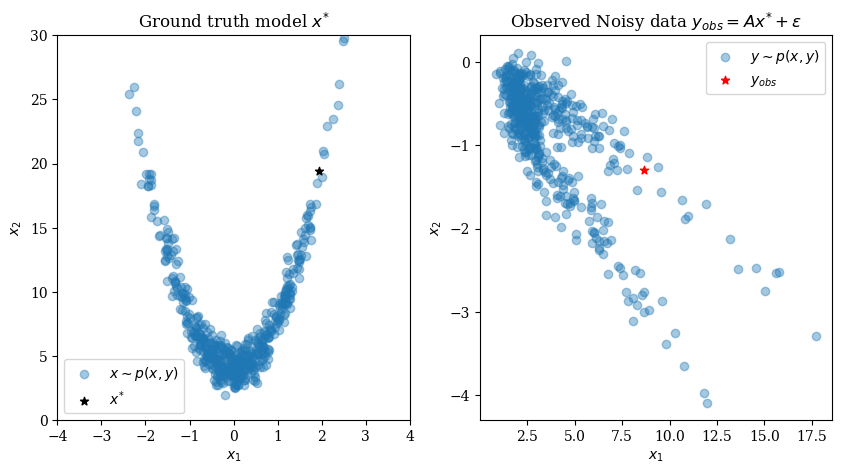

In [41]:
fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"Ground truth model $x^{*}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*", color="black", label = L"x^{*}");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,2,2); title(L"Observed Noisy data $y_{obs} = Ax^{*} + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p(x,y)");
scatter(y_obs[1,1,1,1], y_obs[1,1,2,1]; marker="*", color="red", label = L"y_{obs}");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

## Form conditional distribution given observed data $p(x|y_{obs})$

Remember that the y-lane in HINT is completely independent of the x-lane. This functionality is implemented in  ``H.forward_Y`` which we will call on our observed data to get the corresponding latent variable $z_y$.


In [42]:
zy_fixed = H.forward_Y(y_obs);

Then we can sample directly from the conditional aka posterior distribution $x \sim p(x|y_{obs})$ We do this by resampling $z_x \sim N(0,I)$ and calling the inverse network $H^{-1}(z_x, z_y)$

In [43]:
#fix zy and resample zx many times to generate samples from the conditional distribution p(x|y)
cond_sampling_size = 50
Zx = randn(Float32, nx, ny, n_in, cond_sampling_size)
X_post = H.inverse(Zx, zy_fixed.*ones(Float32, nx, ny, n_in, cond_sampling_size))[1];

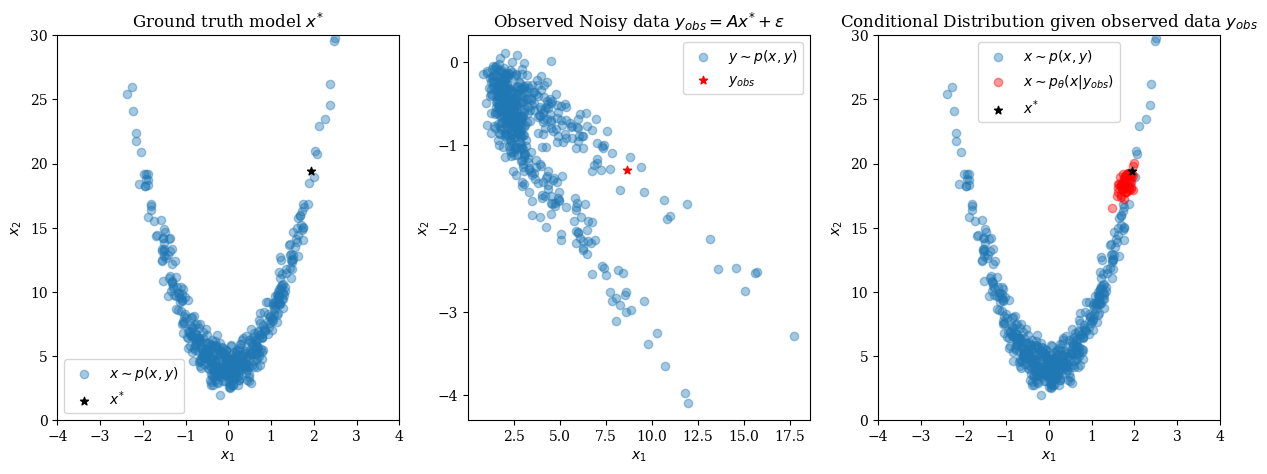

PyObject <matplotlib.legend.Legend object at 0x160d7c550>

In [44]:
fig = figure(figsize=(15,5)); 
subplot(1,3,1); title(L"Ground truth model $x^{*}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*", color="black", label = L"x^{*}");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,3,2); title(L"Observed Noisy data $y_{obs} = Ax^{*} + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p(x,y)");
scatter(y_obs[1,1,1,1], y_obs[1,1,2,1]; marker="*", color="red", label = L"y_{obs}");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

subplot(1,3,3); title(L"Conditional Distribution given observed data $y_{obs}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(X_post[1,1,1,:], X_post[1,1,2,:]; alpha=0.4, color="red", label = L"x \sim p_{\theta}(x | y_{obs})");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*",color="black",  label = L"x^{*}");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend()